<a href="https://colab.research.google.com/github/ssreeramj/langgraph-tutorials/blob/main/react_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [14]:
!pip install -qU langchain langchainhub langgraph openai langchain-groq langchain-openai duckduckgo-search langchain-community chromadb

# Imports

In [18]:
# Standard library imports
import operator
import os
import random


# Third-party imports
from google.colab import userdata
from IPython.display import Image, display
from langchain import hub as lang_hub
from langchain_community.tools import DuckDuckGoSearchRun, DuckDuckGoSearchResults
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors
from langchain_core.tools import StructuredTool, tool
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import END, MessageGraph, StateGraph
from langgraph.prebuilt import ToolInvocation
from langgraph.prebuilt.tool_executor import ToolExecutor
from typing import Annotated, Sequence, TypedDict, Union, Literal
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

from pprint import pprint

# Env variables

In [4]:
# Langsmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "deep-learning-ai-agent-course"

In [5]:
# Groq model
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

# Utility Functions

In [17]:
def display_graph(g):
    display(
        Image(
            g.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

# Simple ReAct (Reason + Act) agent from scratch

In [10]:
llm = ChatGroq(model="llama3-8b-8192")
response = llm.invoke("Hi there")
print(response.content)

Hi! It's nice to meet you. Is there something I can help you with, or would you like to chat?


In [38]:
system_prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [71]:
# define all tools

class SearchEngineInputSchema(BaseModel):
    query: str = Field(..., name="Search Query", description="query to search the internet")

# search engine tool
@tool("web-search", args_schema=SearchEngineInputSchema)
def web_search(query):
    """search the internet for the query and returns responses"""
    search_engine = DuckDuckGoSearchResults(max_results=4, backend="news")
    return search_engine.invoke(query)

In [72]:
ans = web_search.invoke("t20 world cup 2024 winners")
ans

'[snippet: Members of the India 2024 T20 World Cup-winning squad - Shivam Dube, Yashasvi Jaiswal and Sanju Samson - have joined the Men in Blue in Harare ahead of the third game against Zimbabwe., title: [Watch] T20 World Cup winners Shivam Dube, Yashasvi Jaiswal and Sanju Samson join Team India ahead of 3rd game against ZIM, link: https://www.msn.com/en-us/sports/other/watch-t20-world-cup-winners-shivam-dube-yashasvi-jaiswal-and-sanju-samson-join-team-india-ahead-of-3rd-game-against-zim/ar-BB1pFH4c, date: 2024-07-09T12:31:07+00:00, source: Sportskeeda on MSN.com], [snippet: Rohit Sharma led India to victory in the T20 World Cup, joining the ranks of successful captains like Sri Lanka\'s Lasith Malinga and England\'s Paul Co, title: ICC T20 World Cup winners list with captains from 2007 to 2024, link: https://www.msn.com/en-in/sports/cricket/icc-t20-world-cup-winners-list-with-captains-from-2007-to-2024/ar-BB1ple83, date: 2024-07-05T06:20:00+00:00, source: Indiatimes on MSN.com], [snip

In [79]:
tools = [TavilySearchResults(max_results=3)]
tool_executor = ToolExecutor(tools=tools)
llm_with_tools = llm.bind_tools(tools=tools)

In [80]:
class ReactAgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [81]:
# call agent node
def call_agent(state: ReactAgentState):
    chat_history = state["messages"]
    agent_response = llm_with_tools.invoke(chat_history)
    return { "messages": [agent_response] }

# execute tools function
def execute_tool(state: ReactAgentState):
    last_message = state["messages"][-1]

    all_tool_responses = []
    for tool_call in last_message.tool_calls:
        tool_action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"]
        )
        tool_response = tool_executor.invoke(tool_action)
        all_tool_responses.append(ToolMessage(
            content=str(tool_response),
            tool_call_id=tool_call["id"],
            name=tool_call["name"],
        ))

    return { "messages": all_tool_responses }

# check if we have the final answer
def should_continue(state: ReactAgentState):
    last_message = state["messages"][-1]

    if not last_message.tool_calls:
        return "end"

    return "continue"

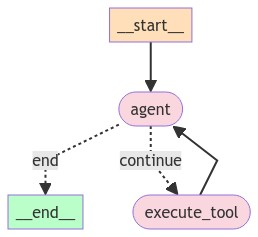

In [82]:
state = StateGraph(ReactAgentState)

state.add_node("agent", call_agent)
state.add_node("execute_tool", execute_tool)

state.add_conditional_edges(
    "agent",
    should_continue,
    {
        "end": END,
        "continue": "execute_tool",
    }
)
state.add_edge("execute_tool", "agent")
state.set_entry_point("agent")

react_agent = state.compile()

display_graph(react_agent)

In [89]:
query = "who won the cricket T20 world cup 2024? what is the population of that country?"

system_message = SystemMessage(content=system_prompt)
human_message = HumanMessage(content=query)

messages = [system_message, human_message]

response = react_agent.invoke({ "messages": messages })

In [90]:
print(response["messages"][-1].content)

The population of South Africa is approximately 62 million people.
